# Westeros Tutorial - Implementation of cooling technologies



In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df
from message_ix.reporting import Reporter
from ixmp.reporting import configure

# configure unit 
configure(units={'replace': {'-': ''}})

<IPython.core.display.Javascript object>

In [2]:
mp = ixmp.Platform(name = 'local')

In [3]:
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='baseline')
scen = base.clone(model, 'cooling_tech_basin', 'illustrating cooling tech using addon',
                  keep_solution=False)
scen.check_out()

In [4]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen.set('year')
country = 'Westeros'

## Retrieve parameters to perform subsequent addition of parameters

In [5]:
#year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen.set('year')
country = 'Westeros'
gdp_profile = pd.Series([1., 1.5, 1.9], index=pd.Index([700, 710, 720], name='Time'))

In [6]:
basin = ('basin_1', 'basin_2','basin_3')

scen.add_spatial_sets({'region': country,'country':basin })

In [7]:
basin = ('basin_1', 'basin_2','basin_3')

scen.add_spatial_sets({'basin':basin })
basin = pd.DataFrame({ "node_parent": ('Westeros','Westeros','Westeros','basin_1', 'basin_2','basin_3'),
                       "node": ('basin_1', 'basin_2','basin_3','basin_1', 'basin_2','basin_3')})
scen.add_set("map_node",basin)

### Define helper functions

In [8]:
base_input1 = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'node_origin': country,
    'commodity': 'electricity',
    'time': 'year',
    'time_origin': 'year',
}

base_input2 = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'node_origin': country,
    #'commodity': 'electricity',
    'time': 'year',
    'time_origin': 'year',
}


base_output = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'node_dest': country,
    'time': 'year',
    'time_dest': 'year', 
    'unit': '%',
}


base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '%',
}

base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'y',
}

base_inv_cost = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'USD/kW',
}

base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/kW',
}

base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/kWa',
}

base_growth = {
    'node_loc': country,
    'year_act': model_horizon,
    'time': 'year',
    'unit': '-',
}

base_capacity = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'GW',
}

base_activity = {
    'node_loc': country,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

## Defining new levels and commodities
Two new `levels` are added to the model:
1. `water_supply_region` 7 `water_supply_basin` will be used to model the water flows across basin and region.
2. `cooling` will be used to model the cooling requirements.

In [9]:
scen.add_set("commodity", ["water_source","water_demand","t_d"])
scen.add_set("level", ["water_supply"])
scen.add_set("technology", ['freshwater_src','saline_src','freshwater', 'groundwater','saline',
                            'water_2_en'])
scen.add_set("mode", ["standard","b1","b2","b3"])

In [10]:
chec
scen.add_set("commodity", ["freshwater_basin","freshwater_region",
                           "salinewater_basin","salinewater_region"])

scen.add_set("level", ["cooling"])
scen.add_set("commodity", ["cooling_req"])

### addon technology - interlinking technologies
In order to demonstrate the use of this feature, we will be adding a new demand for water to this scenario. This demand will be met by the coal_ppl via three cooling technologies, the addon technology.

We will therefore go through the following steps:

#### Cooling technology types
Add new technologies:
1. Once-through cooling by freshwater - `coal_ppl_ot_fresh`
2. Closed loop cooling by freshwater - `coal_ppl_cl_fresh`
3. Once through cooling seawater `coal_ppl_ot_saline`
4. Air cooling `coal_ppl_air`

Link these cooling tehcnologies to the `coal_ppl` using the addon feature.

## Adding freshwater supply & instream extraction as techs

The water supply technologies have only input & output dataframe in model. 

*At some point, we may want to link it to global water supply model in future


In [11]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']

base = {
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}



### Now we define outputs from basins first for freshwater and saline water 
The following outputs is a dummy tec to represent water source. 

In [12]:

tecs = {'freshwater_src': ['freshwater_basin', 1.0, 20]}
        #'saline_src': ['salinewater_basin', 1.0, 20]}


base_output = make_df(base, time_dest='year')
df_out = make_df(base_output, 
                   level='water_supply_basin')


for tec in tecs:
    df_out1 = make_df(df_out,technology = tec,commodity = tecs[tec][0], node_loc = 'basin_1' ,
                      node_dest='basin_1', value=1.0)
    scen.add_par('output', df_out1)

for tec in tecs:
    df_out1 = make_df(df_out,technology = tec,commodity = tecs[tec][0], node_loc = 'basin_2' ,
                      node_dest='basin_2', value=1.0)
    scen.add_par('output', df_out1)    
    
for tec in tecs:
    df_out1 = make_df(df_out,technology = tec,commodity = tecs[tec][0], node_loc = 'basin_3' ,
                      node_dest='basin_3', value=1.0)
    scen.add_par('output', df_out1)    

In [13]:
tecs = {'saline_src': ['salinewater_region', 1.0, 20]}


base_output = make_df(base, time_dest='year')
df_out = make_df(base_output, 
                   level='saline_supply_region')


for tec in tecs:
    df_out1 = make_df(df_out,technology = tec,commodity = 'salinewater_region', node_loc = country ,
                      node_dest= country, value=1.0)
    scen.add_par('output', df_out1)



In [14]:
base = {
    'year_vtg': vintage_years,
    'year_act': act_years,
    #'mode': 'standard',
    'time': 'year',
    'unit': '-',
}


Define inputs from the previous output at same level that takes in techs at basin level and produce outputs at region level such as from `basin 1` to `Westeros`

`water_2_en_b1` & `water_2_en_b2` are tecs that link water supply region to water supply basin. 

In [15]:
# scen.add_set('mode',['fresh','saline'])

In [16]:
tecs = {'water_2_en': ['basin_1', 1.0, 1],
        #'water_2_en_b2': ['basin_2', 1.0, 1]
       }

base_input = make_df(base, time_origin='year')

df_in = make_df(base_input,  level='water_supply_basin')

for tec in tecs:
    df_in1 = make_df(df_in,technology = tec, commodity = 'freshwater_basin',
                     mode = 'b1', node_loc = country, 
                     node_origin= 'basin_1', value=tecs[tec][2])
    scen.add_par('input', df_in1)
for tec in tecs:
    df_in1 = make_df(df_in,technology = tec, commodity = 'freshwater_basin',
                     mode = 'b2', node_loc = country, 
                     node_origin= 'basin_2', value=tecs[tec][2])
    scen.add_par('input', df_in1)
for tec in tecs:
    df_in1 = make_df(df_in,technology = tec, commodity = 'freshwater_basin',
                     mode = 'b3', node_loc = country, 
                     node_origin= 'basin_3', value=tecs[tec][2])
    scen.add_par('input', df_in1)

# for tec in tecs:
#     df_in1 = make_df(df_in,technology = 'saline_supply_ppl', commodity = 'salinewater_region', 
#                      mode = 'standard',node_loc = country , 
#                      node_origin= country , value= 1)
#     scen.add_par('input', df_in1)

In [17]:
# scen.par('input')

Now linking these input values to output for basin water to energy tecs

In [18]:
tecs = {'water_2_en': ['basin_1', 1.0, 1],
        #'water_2_en_b2': ['basin_2', 1.0, 1]
       }

base_output = make_df(base, time_dest='year')
df_out = make_df(base_output,level='water_supply_region')

for tec in tecs:
    df_out1 = make_df(df_out,technology = tec, commodity = 'freshwater_region',
                      mode = 'b1', node_dest = country, node_loc= country, 
                      value=tecs[tec][2])
    scen.add_par('output', df_out1)

for tec in tecs:
    df_out1 = make_df(df_out,technology = tec, commodity = 'freshwater_region',
                      mode = 'b2', node_dest = country, node_loc= country, 
                      value=tecs[tec][2])
    scen.add_par('output', df_out1)

for tec in tecs:
    df_out1 = make_df(df_out,technology = tec, commodity = 'freshwater_region',
                      mode = 'b3', node_dest = country, node_loc= country, 
                      value=tecs[tec][2])
    scen.add_par('output', df_out1)
    
# for tec in tecs:
#     df_out1 = make_df(df_out,technology = 'tec', commodity = 'salinewater_region',
#                       mode = 'saline',node_dest = country, node_loc= country, 
#                       value=tecs[tec][2])
#     scen.add_par('output', df_out1)

In [19]:
# scen.par('output',{'mode':['b1','b2','b3']})

### Defining variable costs for water to energy basin tecs

In [20]:
tecs = {'water_2_en': ['water_supply_region', 1.0, 300]
        #'water_2_en_b2': ['water_supply_region', 1.0, 0.9]
       }
      
for tec in tecs:
#     #scen.add_set('technology', tec)
#     df_out = make_df(base_output, technology=tec, commodity=tecs[tec][0], 
#                      level='water_supply', value=tecs[tec][1])

#     scen.add_par('output', df_out)

    df_var = make_df(base_var_cost, technology=tec, value=tecs[tec][2])
    scen.add_par('var_cost', df_var)

defining shares of basins

In [21]:
shares = 'share_basin'
scen.add_set('shares', shares)

define total basin tecs

In [22]:
# type_tec = 'basin_total'

# basin_tecs = ['water_2_en_b1','water_2_en_b2']
# for b in basin_tecs:
#     scen.add_cat('technology', type_tec, b)
# #scen.add_cat('technology', type_tec, 'water_2_en_b1')

In [23]:
# mp.close_db()

map total share

In [24]:
# # Adding data to a set using index names
# basins = ['basin_1','basin_2']

# for b in basins: 
#     df = pd.DataFrame({'shares': [shares],
#                    'node_share': b,
# #                    'node': country,
#                    'type_tec': type_tec,
#                    'mode': 'fresh',
#                    'commodity': 'freshwater_region',
#                    'level': 'water_supply_region',
# })
#     scen.add_set('map_shares_commodity_total', df)


now map commodity share

In [25]:
# Example of index names of a set
scen.idx_names('share_mode_up')

['shares', 'node_share', 'technology', 'mode', 'year_act', 'time']

In [26]:
scen.idx_names('share_commodity_up')

['shares', 'node_share', 'year_act', 'time']

In [27]:
# type_tec = 'basin_water'

# scen.add_cat('technology', type_tec, 'water_2_en_b1')
modes = ['b1','b2','b3']
basins = ['basin_1','basin_2','basin_3']

modes = {'b1': 0.25,
         'b2': 0.35,
         'b3': 0.4 }
# Reminder: use <scen.idx_names('map_shares_commodity_share')> to see the index names

for mode,value in modes.items(): 
    df = pd.DataFrame({'shares': [shares],
                    'node_share': country,
                    'technology':'water_2_en',
                    'mode': mode,
                    'year_act':710,
                    'time':'year',
                    'value': value
})
scen.add_par('share_mode_up', df)


df = pd.DataFrame({'shares': [shares],
                    'node_share': country,
                    'technology':'water_2_en',
                    'mode': 'b2',
                    'year_act':710,
                    'time':'year',
                    'value': 0.4
})
scen.add_par('share_mode_up', df)

df = pd.DataFrame({'shares': [shares],
                    'node_share': country,
                    'technology':'water_2_en',
                    'mode': 'b3',
                    'year_act':710,
                    'time':'year',
                    'value': 0.3
})
scen.add_par('share_mode_up', df)

df = pd.DataFrame({'shares': [shares],
                    'node_share': country,
                    'technology':'water_2_en',
                    'mode': 'b1',
                    'year_act':710,
                    'time':'year',
                    'value': 0.3
})
scen.add_par('share_mode_up', df)

# for mode,value in modes.items(): 
#     df = pd.DataFrame({'shares': [shares],
#                     'node_share': country,
#                     'technology':'water_2_en',
#                     'mode': mode,
#                     'year_act':700,
#                     'time':'year',
#                     'value': value
# })
# scen.add_par('share_mode_up', df)

df = pd.DataFrame({'shares': [shares],
                    'node_share': country,
                    'technology':'water_2_en',
                    'mode': 'b1',
                    'year_act':700,
                    'time':'year',
                    'value': 0.2
})
scen.add_par('share_mode_up', df)


df = pd.DataFrame({'shares': [shares],
                    'node_share': country,
                    'technology':'water_2_en',
                    'mode': 'b2',
                    'year_act':700,
                    'time':'year',
                    'value': 0.4
})
scen.add_par('share_mode_up', df)

df = pd.DataFrame({'shares': [shares],
                    'node_share': country,
                    'technology':'water_2_en',
                    'mode': 'b3',
                    'year_act':700,
                    'time':'year',
                    'value': 0.4
})
scen.add_par('share_mode_up', df)

# for mode,value in modes.items(): 
#     df = pd.DataFrame({'shares': [shares],
#                     'node_share': country,
#                     'technology':'water_2_en',
#                     'mode': mode,
#                     'year_act':720,
#                     'time':'year',
#                     'value': value
# })
# scen.add_par('share_mode_up', df)

In [28]:
# scen.par('share_mode_up')

In [29]:
# for mode in modes:
    

assuming that the highest share from basin can only be 25 % of total water supply to cooling tech

In [30]:
# # Defining basin share of water to cooling technology such as 25% of water can be consumed at maximum 
# df = pd.DataFrame({'shares': shares,
#                    'node_share': country,
#                    'year_act': [720,],
#                    'time': 'year',
#                    'value': [.65],
#                    'unit': '-'})
# scen.add_par('share_commodity_up', df)

In [31]:
# scen.par('share_commodity_up')

### Now we add parameters for cooling technologies

We will be using `water required per heat output` for cooling technologies as input value of cooling technology types. 


In [32]:
# base_input2

In [33]:
# {techname: [input commodity, input factor, inv_cost, fix_cost, lifetime]}
tecs = {'coal_ppl_ot_fresh': ['freshwater_region','water_supply_region', 0.938, 600., 0., 30.],
        'coal_ppl_cl_fresh': ['freshwater_region','water_supply_region', 0.017, 160., 0., 30., 
                              ['secondary', 'electricity','water_supply_region', 0.017]],
        #'coal_ppl_ot_saline': ['salinewater_region','saline_supply_region', 0.938, 150., 0., 30],
        'coal_ppl_air': ['electricity','secondary', 0.102, 0.0, 430., 30, 30,
                         ['secondary', 'electricity', 0.102]],
        }

for tec in tecs:
    scen.add_set('technology', tec)

    if tecs[tec][0]:
        df_inp = make_df(base_input2, technology=tec, commodity=tecs[tec][0],  
                         level= tecs[tec][1], value=tecs[tec][2], unit='-')
        scen.add_par('input', df_inp)

    if tec not in ['coal_ppl_ot_fresh', 'coal_ppl_ot_saline']:
        df_inv = make_df(base_inv_cost, technology=tec, value=tecs[tec][3])
        scen.add_par('inv_cost', df_inv)

    df_fix = make_df(base_fix_cost, technology=tec, value=tecs[tec][4])
    scen.add_par('fix_cost', df_fix)

    df_tl = make_df(base_technical_lifetime, technology=tec, value=tecs[tec][5])
    scen.add_par('technical_lifetime', df_tl)
    
#     if len(tecs[tec]) > 5:
#         df_inp = make_df(base_input2, technology=tec, commodity=tecs[tec][5][1],  
#                          level=tecs[tec][5][0], value=tecs[tec][5][2], unit='-')
#         scen.add_par('input', df_inp)

In [34]:
# scen.par('technical_lifetime')

## Addon mapping 
We try to define a single `type_addon` for each power plant. Here we use `coal_ppl` as an example. 

`type_addon` refers to cooling technologies for `coal_ppl` ,whereas `addon` refers to cooling technology types. 

In [35]:
# If we need to add more power plants, we will be using more type_addon here and use the heat rate or cooling requirement per unit of output here
type_addon = 'coal_ppl_cooling'

# Adding cooling technology types 
addon = list(tecs.keys())

scen.add_set('addon', pd.DataFrame({'technology': addon})) 

# Parent technology to map 
parent_tec = 'coal_ppl'

# Mapping addon with type_addon and parent tech
scen.add_cat('addon', type_addon, addon)
scen.add_set('map_tec_addon', pd.DataFrame({'technology': parent_tec,
                                            'type_addon': [type_addon]}))

In this case, we use addon conversion factor for each `type_addon`.Addon conversion factor refers to the heat produced by the parent technology (in this case `coal_ppl`) that is needed to be cooled. 
For now for simplicity, we are referring to heat rate which is 1/efficiency. In the current scenario would be 5. 

In [36]:
df = pd.DataFrame({'node': country,
                   'technology': parent_tec,
                   'year_vtg': vintage_years,
                   'year_act': act_years,
                   'mode': 'standard',
                   'time': 'year',
                   'type_addon': type_addon,
                   'value': 2,
                   'unit': '%'})

scen.add_par('addon_conversion', df)

Now we bound the activity of `cool_coal_ppl` to 100% share of `coal_ppl` to make sure that all of the heat produced is being cooled.

In [37]:
df = pd.DataFrame({'node': country,
                   'technology': parent_tec,
                   'year_act': act_years,
                   'mode': 'standard',
                   'time': 'year',
                   'type_addon': type_addon,
                   'value': 1,
                   'unit': '%'})
scen.add_par('addon_lo', df)

## Commit & Solve 

In [38]:
scen.commit(comment='implement cooling tech')
scen.set_as_default()

In [39]:
scen.solve()

## Using reporting features to see the output of cooling technology. 

The output dataframe here shows the water required per heat rate of `coal_ppl` (as per our understanding)

In [40]:
# Create a reporter from the existing Scenario
rep = Reporter.from_scenario(scen)

def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = df['t']
    return df.drop(['t'], axis=1)

/Users/MuhammadAwais/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: This method is deprecated and will be removed in future versions. Please use `plot.bar()`.
  import sys


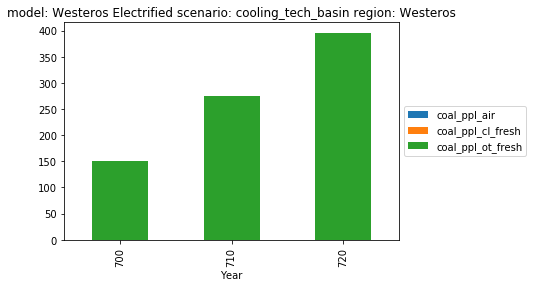

In [41]:
df = rep.full_key('in')
new_key = rep.convert_pyam(
    quantities=df.drop('yv', 'm', 'h', 'ho', 'no', 'c', 'l'),
    year_time_dim='ya',
    collapse=collapse_callback)
water_use = rep.get(new_key[0])
water_use.filter(variable=addon).bar_plot(stacked=True)

In [42]:
mp.close_db()